# 2.6 SubGraph: LangGraph Agent를 Node로 활용하는 방법

- [Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity](https://arxiv.org/abs/2403.14403)논문을 구현합니다
- LangGraph 공식문서의 흐름을 따라갑니다
    - 공식문서의 흐름은 간소화된 버전입니다
    - 실제 논문과 유사한 구현은 3.3강을 참고해주세요

![adaptive-rag](./images/adaptive-rag.png)

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [3]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState):
    query = state['query']
    results = tavily_search_tool.invoke(query)
    print(f'web search results == {results}')
    return {'context': results}

In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model="gpt-4o")

def web_generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response}

/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- 간단한 질문에 답변을 하는 경우 작은 모델을 활용해서 비용을 저감하고, 답변 생성 속도를 향상시킬 수 있습니다

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

basic_llm = ChatOpenAI(model="gpt-4o-mini")

def basic_generate(state: AgentState):
    query = state['query']
    basic_llm_chain = basic_llm | StrOutputParser()
    llm_response = basic_llm_chain.invoke(query)
    return {'answer': llm_response}

- 사용자의 질문이 들어오면 `router` 노드에서 사용자의 질문을 분석해서 적절한 노드로 이동합니다
    - 사용자의 질문에 관한 내용이 vector store에 있는 경우 `income_tax_agent` 노드로 이동합니다
    - 사용자의 질문이 간단한 경우 `basic_generate` 노드로 이동합니다
    - 사용자의 질문이 웹 검색을 통해 답변을 얻을 수 있는 경우 `web_search` 노드로 이동합니다

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""


router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

router_llm = ChatOpenAI(model="gpt-4o-mini")
structured_router_llm = router_llm.with_structured_output(Route)

def router(state: AgentState):
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})

    return route.target

- `node`를 추가하고 `edge`로 연결합니다

In [7]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node('income_tax_agent', income_tax_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [8]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START, 
    router,
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [9]:
graph = graph_builder.compile()

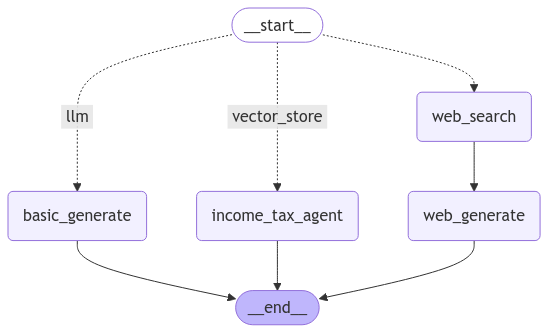

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
initial_state = {'query': '대한민국의 수도는 어디인가요?'}
graph.invoke(initial_state)

router route == target='llm'
route.target == llm


{'query': '대한민국의 수도는 어디인가요?', 'answer': '대한민국의 수도는 서울입니다.'}

In [12]:
initial_state = {'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

router route == target='vector_store'
route.target == vector_store
context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종

{'query': '연봉 5천만원인 사람의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산

In [13]:
initial_state = {'query': '역삼 맛집을 추천해주세요'}
graph.invoke(initial_state)

router route == target='web_search'
route.target == web_search
web search results == [{'url': 'https://forourtour.com/역삼동-맛집/', 'content': '역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 국내 맛집 역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 관련 검색어에는 서울 역삼동 맛집 추천 베스트 한식 일식 술집 점심 저녁 핫플 역삼역 강남역 센터필드 데이트 놀거리 지도 음식점 분위기 재방문 리뷰 리스트 입니다. 역삼동 맛집 추천 모음 호보식당: 역삼역 핫플 마늘갈비 추천 맛집 – 홈페이지 바로가기 이 곳의 대표 메뉴인 마늘갈비는 마늘 양념이 잔뜩 올라간 갈비로, 바질, 할라피뇨, 고수로 만든 특제 소스 조합으로 함께 먹으면 더욱 맛있다고 합니다. 떡도리탕: 역삼동 점심 저녁 추천 맛집 – 거리뷰 바로가기 유니네 고깃간: 역삼동 저녁 추천 고기 맛집 – 거리뷰 바로가기 사이드 메뉴인 김치말이냉국수도 맛있다고 하니 함께 드셔보시길 추천합니다. 미도인 강남: 역삼동 데이트 추천 스테이크 맛집 – 거리뷰 바로가기'}, {'url': 'https://jspringlife.com/entry/역삼역-맛집-💖-요즘-뜨겁게-핫한-역삼역-맛집-Top-8-😎🔥', 'content': "[역삼역 맛집 💖] 요즘 뜨겁게 핫한 역삼역 맛집 Top 8 😎🔥 [역삼역 맛집 💖] 요즘 뜨겁게 핫한 역삼역 맛집 Top 8 😎🔥 데이트 명소가 너무나 많은 역삼역 맛집에 대해서 알아볼 예정이에요. 그럼 역삼역 맛집 리뷰 시작할게요. [역삼역 맛집 💖] 요즘 뜨겁게 핫한 역삼역 맛집 Top 8 😎🔥 역삼역 맛집!! ✔ 후라토식당 매장 안내 주소 : 서울 강남구 테헤란로 152 지하 1층 P9호 ✔ 동화고옥 매장 안내 주소 : 서울 강남구 테헤란로 129 강남N타워 B2층 '모도우'란 빈틈없이 야무진 사람의 순우리말인 '모도리'와 소 우(牛

{'query': '역삼 맛집을 추천해주세요',
 'context': [{'url': 'https://forourtour.com/역삼동-맛집/',
   'content': '역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 국내 맛집 역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 관련 검색어에는 서울 역삼동 맛집 추천 베스트 한식 일식 술집 점심 저녁 핫플 역삼역 강남역 센터필드 데이트 놀거리 지도 음식점 분위기 재방문 리뷰 리스트 입니다. 역삼동 맛집 추천 모음 호보식당: 역삼역 핫플 마늘갈비 추천 맛집 – 홈페이지 바로가기 이 곳의 대표 메뉴인 마늘갈비는 마늘 양념이 잔뜩 올라간 갈비로, 바질, 할라피뇨, 고수로 만든 특제 소스 조합으로 함께 먹으면 더욱 맛있다고 합니다. 떡도리탕: 역삼동 점심 저녁 추천 맛집 – 거리뷰 바로가기 유니네 고깃간: 역삼동 저녁 추천 고기 맛집 – 거리뷰 바로가기 사이드 메뉴인 김치말이냉국수도 맛있다고 하니 함께 드셔보시길 추천합니다. 미도인 강남: 역삼동 데이트 추천 스테이크 맛집 – 거리뷰 바로가기'},
  {'url': 'https://jspringlife.com/entry/역삼역-맛집-💖-요즘-뜨겁게-핫한-역삼역-맛집-Top-8-😎🔥',
   'content': "[역삼역 맛집 💖] 요즘 뜨겁게 핫한 역삼역 맛집 Top 8 😎🔥 [역삼역 맛집 💖] 요즘 뜨겁게 핫한 역삼역 맛집 Top 8 😎🔥 데이트 명소가 너무나 많은 역삼역 맛집에 대해서 알아볼 예정이에요. 그럼 역삼역 맛집 리뷰 시작할게요. [역삼역 맛집 💖] 요즘 뜨겁게 핫한 역삼역 맛집 Top 8 😎🔥 역삼역 맛집!! ✔ 후라토식당 매장 안내 주소 : 서울 강남구 테헤란로 152 지하 1층 P9호 ✔ 동화고옥 매장 안내 주소 : 서울 강남구 테헤란로 129 강남N타워 B2층 '모도우'란 빈틈없이 야무진 사람의 순우리말인 '모도리'와 소 우(牛)의 합성으로 '야무지게 차려낸 한우 다이닝'을 의미합니다. ✔ 모도